<h1> Small features </h1>

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import scipy.stats as stats

# Importing the data

In [2]:
#read a txt file and convert it to a dataframe
def read_txt(path):
    df = pd.read_csv(path, sep='\t', header=None)
    return df

In [3]:
# import the data
plots = pd.read_csv('MovieSummaries/plot_summaries.txt',header=None, sep="\t")
movies = pd.read_csv('MovieSummaries/movie.metadata.tsv',header=None, sep="\t")
characters = pd.read_csv('MovieSummaries/character.metadata.tsv',header=None, sep="\t")
names = pd.read_csv('MovieSummaries/name.clusters.txt',header=None, sep="\t")
tvtropes = pd.read_csv('MovieSummaries/tvtropes.clusters.txt',header=None, sep="\t")

In [4]:
plots.columns = ['wikipedia_movie_id', 'plot']

`movies` data

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)

In [5]:
movies.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'name', 'release_date', 'revenue', 'runtime', 'languages', 'countries', 'genres']

In [6]:
# extracting the years from the release date feature
movie_with_date = movies[-movies["release_date"].isna()].copy(deep=True)
dates = movie_with_date["release_date"]
date_years = dates.astype(str).str.extract(r'(\d{4})')

`characters` data:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID

In [7]:
characters.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'release_date', 'character_name', 'date_of_birth', 'gender', 'height', 'ethnicity', 'name', 'age_at_release', 'freebase_character_map_id', 'freebase_caracter_id', 'freebase_actor_id']

In [8]:
date_years["index"] = date_years.index
date_years.columns = ["year", "index"]

In [9]:
movies["index"] = movies.index

In [10]:
merged = pd.merge(movies, date_years, on="index", how="left")
merged.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,index,year
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0,2001
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",1,2000
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",2,1988


# Revenue analysis over `Country` & `Language`

## Processing the `Country`, `Language` and `Genre` data

For each movie is given a string format dictionary which contains the keys and values to different countries. The same goes for the languages. The goal of this part is to interpret these strings into values and split them, creating 1 row for each country and language of a movie. Once processed, the dataframes are saved in their corresponding `csv` files.

In [11]:
import ast
import pickle

In [12]:
processed_directory = "processed_data"
try:
    os.makedirs(processed_directory)
except:
    pass

In [13]:
for key in ast.literal_eval(merged["countries"][5]).keys():
    print(key)

/m/09c7w0


In [14]:
# country dataframe & dictionary
try:
    movie_countries     = pd.read_csv(processed_directory + "/movie_countries.csv")
    country_dictionary  = pickle.load(open(processed_directory + "/country_dictionary.pickle", "rb"))

except:
    movie_countries = pd.DataFrame(columns=["wikipedia_movie_id", "country_id"])
    country_dictionary = {}
    for i in tqdm(range(merged.shape[0])):
        wikiID = merged["wikipedia_movie_id"][i]
        dico = ast.literal_eval(merged["countries"][i])
        data = [{'wikipedia_movie_id': wikiID, 'country_id': key} for key in dico.keys()]
        dataframe = pd.DataFrame(data)
        movie_countries = pd.concat([movie_countries, dataframe], axis=0)
        country_dictionary.update(dico)

    # save the dataframe to csv
    movie_countries.to_csv(processed_directory + "/movie_countries.csv", index=False)

    # dump the dictionary to pickle
    with open(processed_directory + '/country_dictionary.pickle', 'wb') as handle:
        pickle.dump(country_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
# language dataframe & dictionary
try:
    movie_languages     = pd.read_csv(processed_directory + "/movie_languages.csv")
    language_dictionary = pickle.load(open(processed_directory + "/language_dictionary.pickle", "rb"))
except:
    movie_languages = pd.DataFrame(columns=["wikipedia_movie_id", "language_id"])
    language_dictionary = {}
    for i in tqdm(range(merged.shape[0])):
        wikiID = merged["wikipedia_movie_id"][i]
        dico = ast.literal_eval(merged["languages"][i])
        data = [{'wikipedia_movie_id': wikiID, 'language_id': key} for key in dico.keys()]
        dataframe = pd.DataFrame(data)
        movie_languages = pd.concat([movie_languages, dataframe], axis=0)
        language_dictionary.update(dico)

    # save the dataframe to csv
    movie_languages.to_csv(processed_directory + "/movie_languages.csv", index=False)

    # dump the dictionary to pickle
    with open(processed_directory + '/language_dictionary.pickle', 'wb') as handle:
        pickle.dump(language_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
try:
    movie_genres        = pd.read_csv(processed_directory + "/movie_genres.csv")
    genre_dictionary   = pickle.load(open(processed_directory + "/genre_dictionary.pickle", "rb"))
except:
    movie_genres = pd.DataFrame(columns=["wikipedia_movie_id", "genre_id"])
    genre_dictionary = {}
    for i in tqdm(range(merged.shape[0])):
        wiki_id = movies["wikipedia_movie_id"][i]
        dico = ast.literal_eval(merged["genres"][i])
        data = [{'wikipedia_movie_id': wiki_id, 'genre_id': key} for key in dico.keys()]
        dataframe = pd.DataFrame(data)
        movie_genres = pd.concat([movie_genres, dataframe], axis=0)
        genre_dictionary.update(dico)
    
    # save the dataframe to csv
    movie_genres.to_csv(processed_directory + "/movie_genres.csv", index=False)

    # dump the dictionary to pickle
    with open(processed_directory + '/genre_dictionary.pickle', 'wb') as handle:
        pickle.dump(genre_dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

We can now start by properly merging in the two new dataframes we created:

In [17]:
merged_languages    = pd.merge(merged, movie_languages, on="wikipedia_movie_id", how="inner")
merged_countries    = pd.merge(merged_languages, movie_countries, on="wikipedia_movie_id", how="inner")
merged_all          = pd.merge(merged_countries, movie_genres, on="wikipedia_movie_id", how="inner")
merged_all.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,index,year,language_id,country_id,genre_id
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0,2001,/m/02h40lc,/m/09c7w0,/m/01jfsb
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0,2001,/m/02h40lc,/m/09c7w0,/m/06n90
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0,2001,/m/02h40lc,/m/09c7w0,/m/03npn


We can also replace the language and country ids by their corresponding values

In [18]:
merged_all["language_id"].replace(language_dictionary, inplace=True)
merged_all["country_id"].replace(country_dictionary, inplace=True)
merged_all["genre_id"].replace(genre_dictionary, inplace=True)

#rename language_id as language, country_id as country and genre_id as genre
merged_all.rename(columns={"language_id": "language", "country_id": "country", "genre_id": "genre"}, inplace=True)
merged_all.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,index,year,language,country,genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0,2001,English Language,United States of America,Thriller
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0,2001,English Language,United States of America,Science Fiction
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0,2001,English Language,United States of America,Horror


<Axes: title={'center': 'Number of movies per region for top 20 \n most producing nations'}, xlabel='Country', ylabel='Number of movies'>

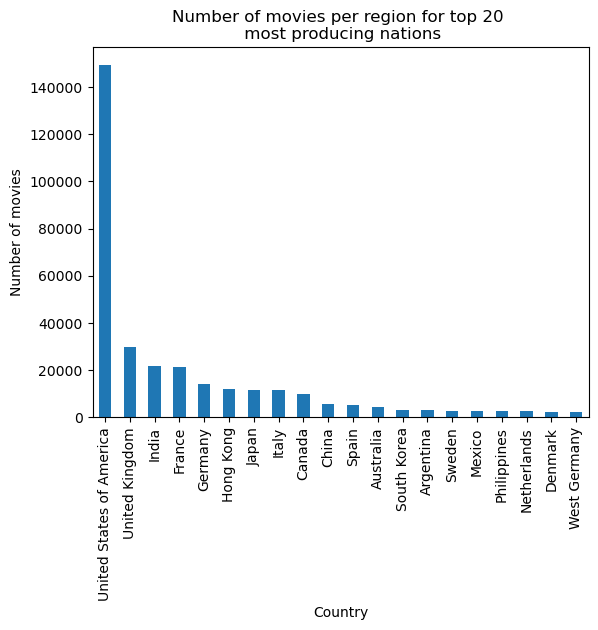

In [19]:
movies_per_region   = merged_all.groupby("country").count()["wikipedia_movie_id"]
movies_per_region.sort_values(ascending=False).head(20).plot(kind="bar", title="Number of movies per region for top 20 \n most producing nations", xlabel="Country", ylabel="Number of movies")

The US clearly dominate the movie industry production.

<Axes: title={'center': 'Number of movies per language for top 20 \n most producing languages'}, xlabel='Language', ylabel='Number of movies'>

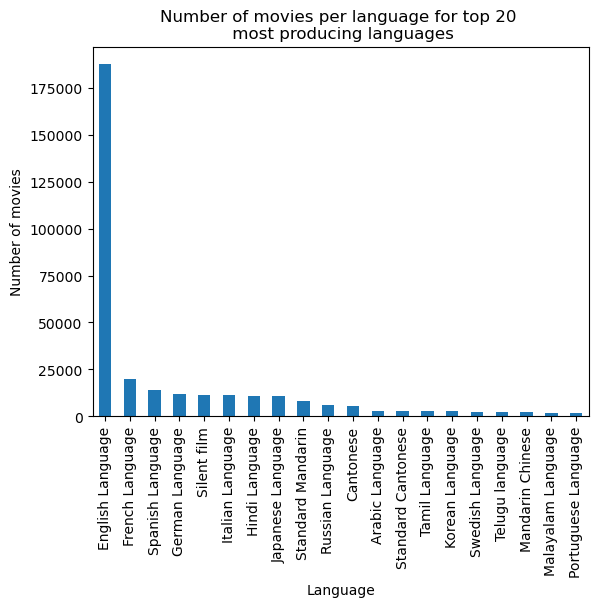

In [20]:
movies_per_language = merged_all.groupby("language").count()["wikipedia_movie_id"]
movies_per_language.sort_values(ascending=False).head(20).plot(kind="bar", title="Number of movies per language for top 20 \n most producing languages", xlabel="Language", ylabel="Number of movies")

English is with no surprise the most used language

## Adjusting for inflation

In [21]:
us_inflation = pd.read_csv("US_yearly_inflation.csv")
us_yearly_inflation = us_inflation[["Year", "Avg-Avg"]].fillna(0)
us_yearly_inflation.rename(columns={"Year": "year", "Avg-Avg": "avg_avg"}, inplace=True)
us_yearly_inflation.head(3)

,year,avg_avg
0,1913,0.0
1,1914,1.0
2,1915,1.0


In [22]:
prices = [1] # we set the initial price as a reference

# Calculate prices based on inflation rates
for index, row in us_yearly_inflation.iterrows():
    if index == 0:
        continue # Skip the first row (no inflation data for the initial price)
    price = prices[-1] * (1 + row['avg_avg'] / 100)
    prices.append(price)

# Add the prices to the DataFrame
us_yearly_inflation['price'] = prices

<Axes: title={'center': 'Price in USD Adjusted for Inflation'}, xlabel='Year', ylabel='Price in USD with 1$ reference of 1913'>

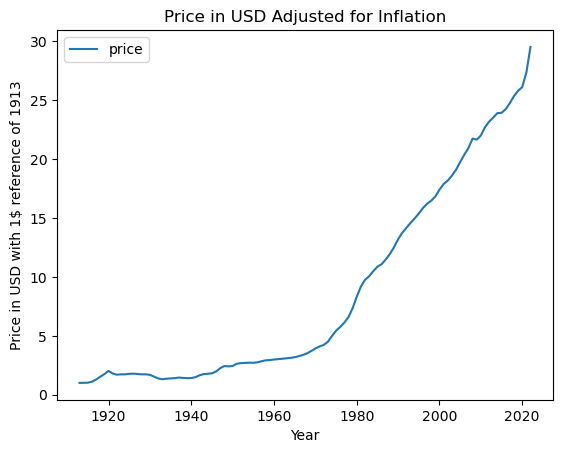

In [23]:
us_yearly_inflation.plot(x = "year", y = "price", title="Price in USD Adjusted for Inflation", xlabel="Year", ylabel="Price in USD with 1$ reference of 1913")

In [24]:
reference_price = us_yearly_inflation[us_yearly_inflation["year"]==2012]["price"].values[0]
correction_factor = reference_price / us_yearly_inflation["price"]
us_yearly_inflation["correlation_factor"] = correction_factor
us_yearly_inflation.drop(columns=['price', 'avg_avg'], inplace=True)
us_yearly_inflation.head(3)

,year,correlation_factor
0,1913,23.178284
1,1914,22.948796
2,1915,22.721580


There are a few movies with missing years. We should remove them.

In [25]:
merged_all["year"].isna().value_counts()

year
False    349235
True       5751
Name: count, dtype: int64

In [26]:
# removing missing years
merged_with_year = merged_all[-merged_all["year"].isna()].copy(deep=True)
merged_with_year["year"].isna().value_counts()

year
False    349235
Name: count, dtype: int64

In [27]:
# converting to numeric values
merged_with_year["year"] = pd.to_numeric(merged_with_year["year"])

In [28]:
# merging with inflation rates
merged_with_inflation = pd.merge(merged_with_year, us_yearly_inflation, on="year", how="left")

# inflation adjusted revenue
merged_with_inflation["adjusted_revenue"] = merged_with_inflation["revenue"] * merged_with_inflation["correlation_factor"]
merged_with_inflation.head(3)

,wikipedia_movie_id,freebase_movie_id,name,release_date,revenue,runtime,languages,countries,genres,index,year,language,country,genre,correlation_factor,adjusted_revenue
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0,2001,English Language,United States of America,Thriller,1.295952,1.815737e+07
1,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0,2001,English Language,United States of America,Science Fiction,1.295952,1.815737e+07
2,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",0,2001,English Language,United States of America,Horror,1.295952,1.815737e+07


Plotting the adjusted total revenue:

<Axes: title={'center': 'Total revenue per country adjusted for inflation'}, xlabel='Country', ylabel='Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012'>

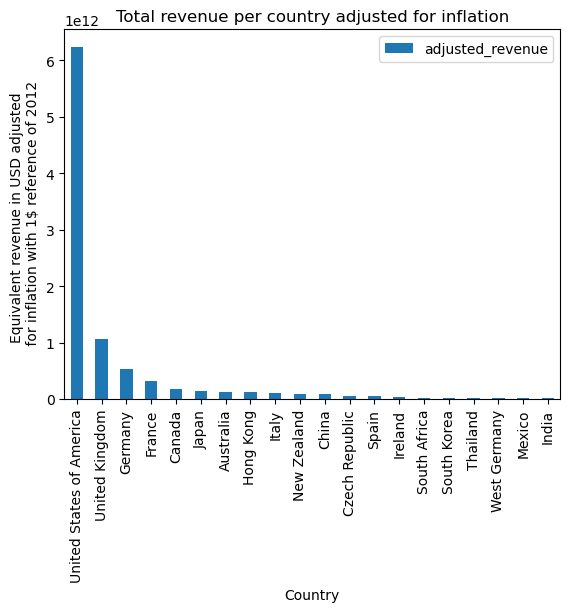

In [29]:
inflation_group = merged_with_inflation.groupby(["country"]).agg({"adjusted_revenue": "sum"})
inflation_group.sort_values(by="adjusted_revenue", ascending=False).head(20).plot(kind="bar", title="Total revenue per country adjusted for inflation", xlabel="Country", ylabel="Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012")

In [30]:
# Top 20 countries that have generated the most total revenue
top_20_countries = inflation_group.sort_values(by="adjusted_revenue", ascending=False).head(20).index.values

<Axes: title={'center': 'Total revenue per language adjusted for inflation'}, xlabel='Language', ylabel='Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012'>

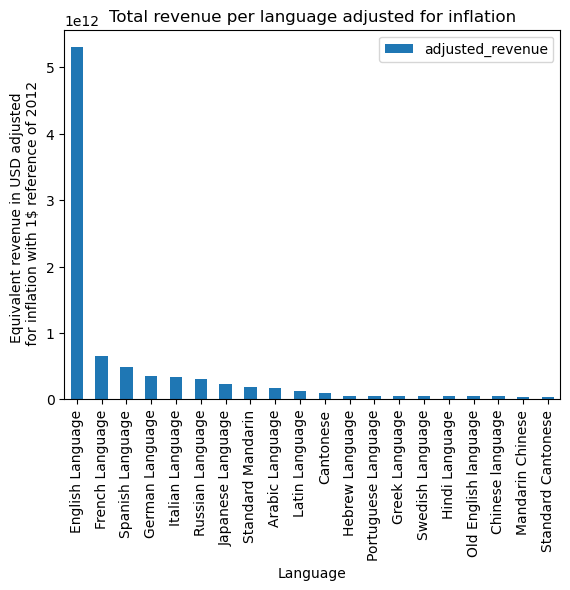

In [31]:
# plotting the average revenue per language adjusted for inflation
inflation_language_group = merged_with_inflation.groupby(["language"]).agg({"adjusted_revenue": "sum"})
inflation_language_group.sort_values(by="adjusted_revenue", ascending=False).head(20).plot(kind="bar", title="Total revenue per language adjusted for inflation", xlabel="Language", ylabel="Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012")

Following the evolution over the years of the 20 countries that have generated the most total revenue

In [32]:
top_20_merged   = merged_with_inflation[merged_with_inflation["country"].isin(top_20_countries)]
top_20_merged.dropna(subset=["adjusted_revenue"], inplace=True)
top_20_grouped  = top_20_merged.groupby(["year", "country"])
top_20_sum      = top_20_grouped.agg({"adjusted_revenue": "sum"})

C:\Users\antho\AppData\Local\Temp\ipykernel_2028\1527462329.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_20_merged.dropna(subset=["adjusted_revenue"], inplace=True)


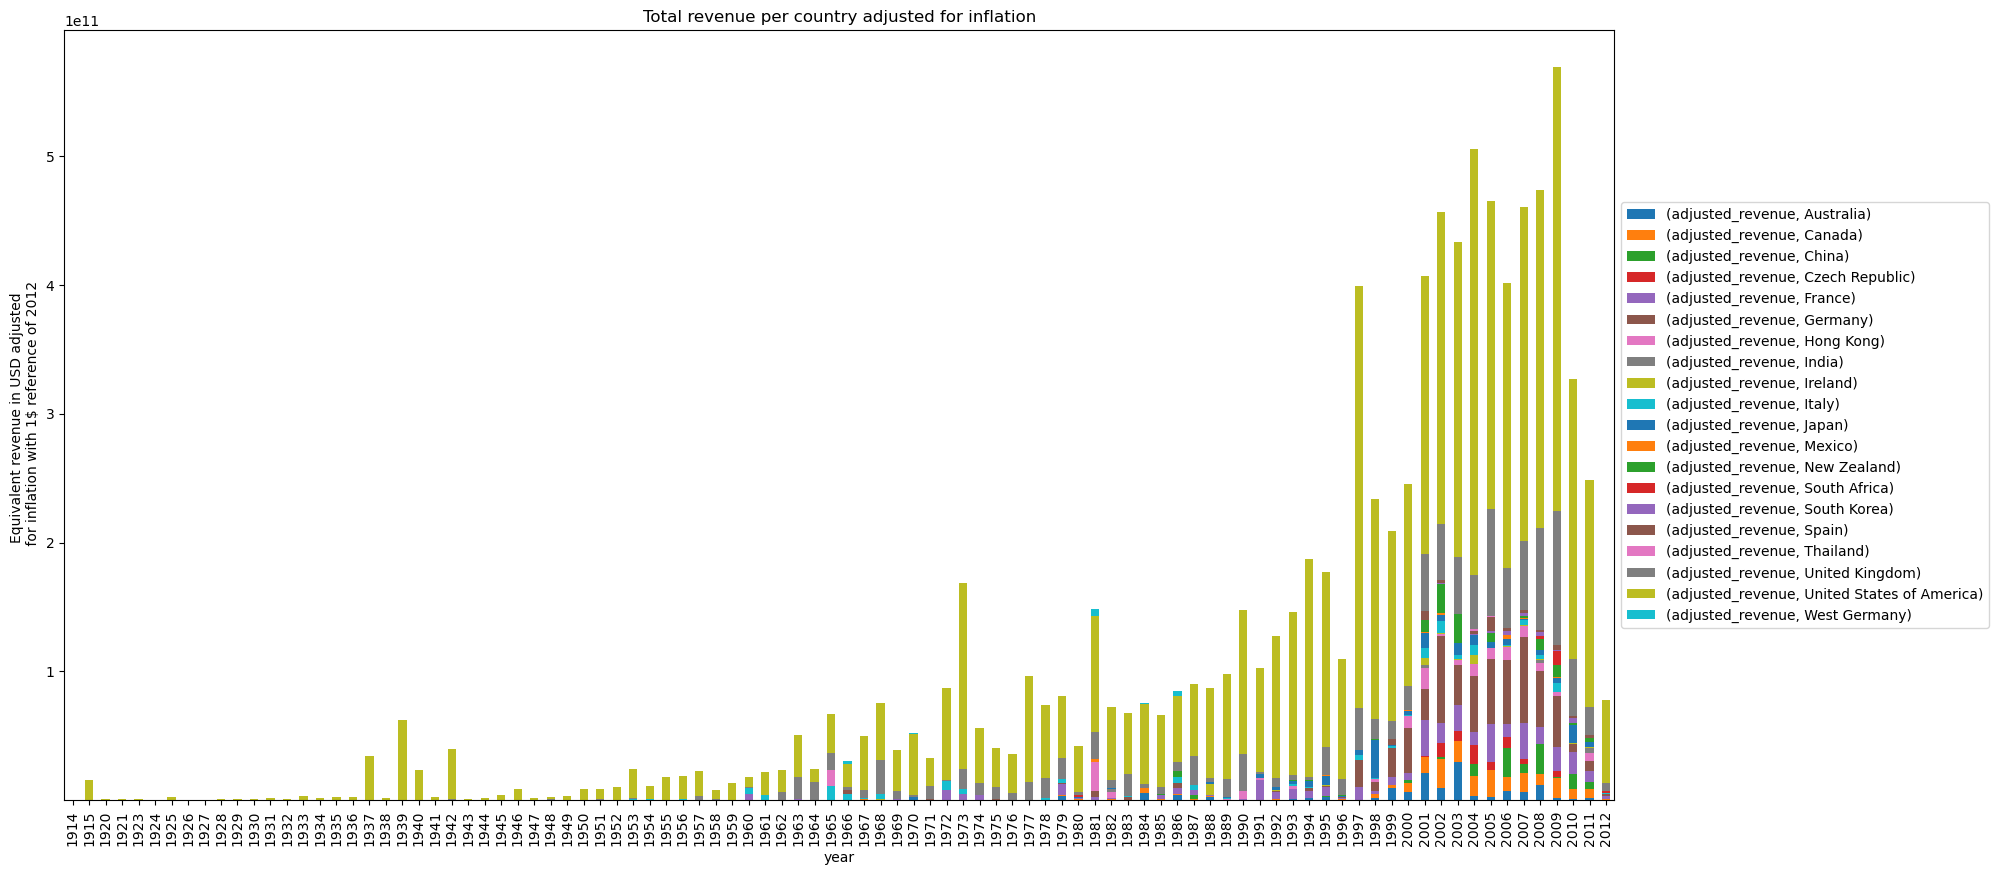

In [33]:
ax = top_20_sum.unstack().plot(kind='bar', stacked=True, title="Total revenue per country adjusted for inflation", xlabel="year", ylabel="Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012", figsize=(20,10))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We clearly see that globally, the movie industry has been making more money over the years. Though we see a drop during the years that follow 2008 which might be a consequence of the subprime's crisis.

The US dominance remains present even when looking at year-by-year movies revenue adjusted for inflation. The US has been the most productive country in terms of movies production and revenue generation for the past 100 years.

# Revenue analysis over the length of a movie

Aboout 35 movies have a runtime that is longer that 500 minutes, which does not make sense.

In [34]:
merged_with_inflation[merged_with_inflation["runtime"]>=500]["runtime"].describe()

count    1.360000e+02
mean     4.063671e+04
std      2.036696e+05
min      5.400000e+02
25%      5.440000e+02
50%      6.040000e+02
75%      9.000000e+02
max      1.079281e+06
Name: runtime, dtype: float64

We can remove these outliers and perform a `pearson correlation` test between the `movie_runtime` and its `adjusted_revenue`

In [35]:
merged_with_inflation_no_outlier    = merged_with_inflation[merged_with_inflation["runtime"]<500]
non_nan_merged_with_inflation       = merged_with_inflation_no_outlier[~merged_with_inflation_no_outlier["adjusted_revenue"].isna()]
non_nan_merged_with_inflation       = non_nan_merged_with_inflation[~non_nan_merged_with_inflation["runtime"].isna()]
stats.pearsonr(non_nan_merged_with_inflation["runtime"], non_nan_merged_with_inflation["adjusted_revenue"])

PearsonRResult(statistic=0.24686719894658166, pvalue=0.0)

The p_value is low enough, we can trust the value of Pearson's coefficient `r=0.25` which indicates a weak positive correlation between `runtime` of a movie and its `adjusted_revenue`

c:\Users\antho\.conda\envs\ada\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Revenue vs Runtime')

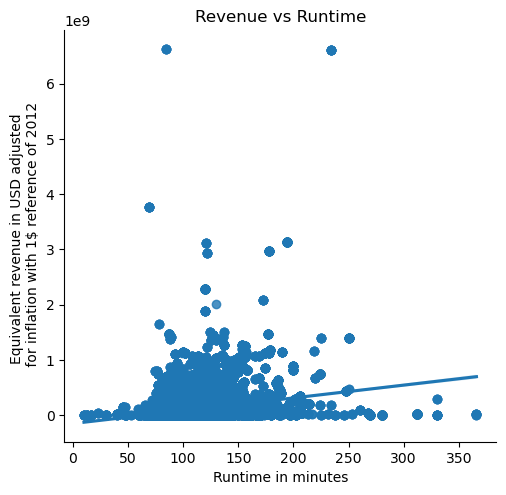

In [36]:
# plotting revenue vs runtime with a linear regression
sns.lmplot(x="runtime", y="adjusted_revenue", data=non_nan_merged_with_inflation)
plt.xlabel("Runtime in minutes")
plt.ylabel("Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012")
plt.title("Revenue vs Runtime")

In [37]:
non_nan_merged_with_inflation["runtime"].describe()

count    86370.000000
mean       111.098564
std         24.428863
min         10.000000
25%         95.000000
50%        107.000000
75%        121.000000
max        366.000000
Name: runtime, dtype: float64

# Augmented data analysis

In [38]:
# reading the imdb scraped data
n_computer = 6
csv_file = r"./MovieSummaries/imdb_scraped_dataset.csv"
try:
    partition_dataset = pd.read_csv(csv_file)
except:
    partition_file = r"partitions/imdb_scraped_data_"
    partition_dataset = pd.read_csv(partition_file + '0.csv')

    for i in range(1, n_computer):
        partition = partition_file + str(i) + '.csv'
        partition_dataset = pd.concat([partition_dataset, pd.read_csv(partition)], axis=0)
        partition_dataset.to_csv(csv_file, index=False)

In [39]:
scraped_merge = pd.merge(merged_with_inflation, partition_dataset, on="wikipedia_movie_id")
scraped_merge.head(3)
scraped_merge.shape

(349235, 26)

Plotting the 20 producers that have generated the most revenue over their carreer 

<Axes: title={'center': 'Total revenue per producer adjusted for inflation\n for top 20 generating producers'}, xlabel='Producer', ylabel='Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012'>

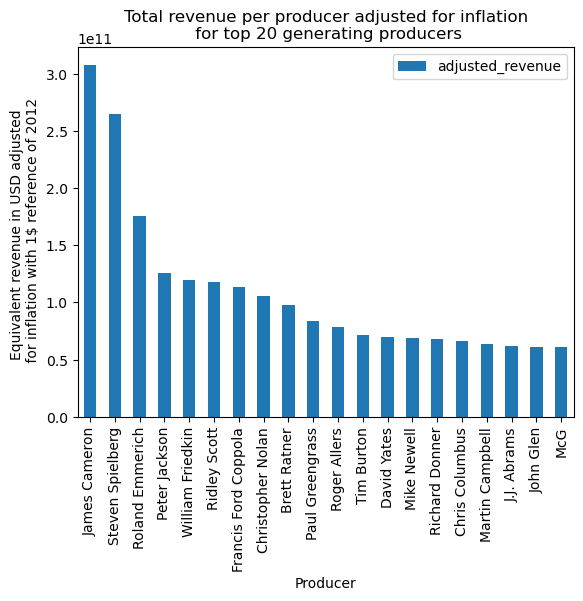

In [40]:
scraped_grouped = scraped_merge.groupby(["producer"]).agg({"adjusted_revenue": "sum"})
scraped_grouped.sort_values(by="adjusted_revenue", ascending=False).head(20).plot(kind="bar", title="Total revenue per producer adjusted for inflation\n for top 20 generating producers", xlabel="Producer", ylabel="Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012")

`Adjusted Revenue` and `Rating` correlation analysis

<Axes: title={'center': 'Revenue vs Rating'}, xlabel='Rating', ylabel='Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012'>

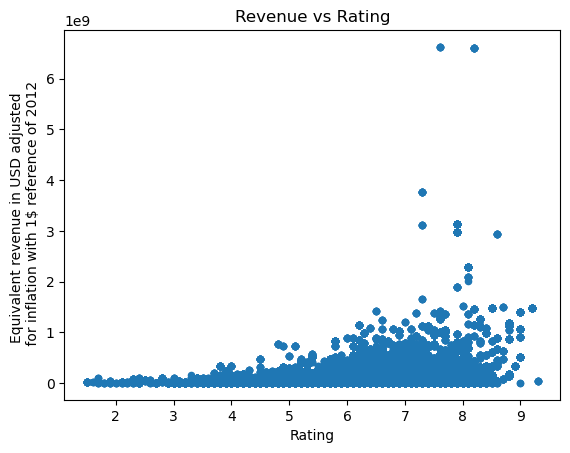

In [41]:
# plot revenue adjusted against rating score
scraped_merge.plot(kind="scatter", x="rating_score", y="adjusted_revenue", title="Revenue vs Rating", xlabel="Rating", ylabel="Equivalent revenue in USD adjusted \n for inflation with 1$ reference of 2012")

In [42]:
non_nan_scraped_merge = scraped_merge[~scraped_merge["rating_score"].isna()]
non_nan_scraped_merge = non_nan_scraped_merge[~non_nan_scraped_merge["adjusted_revenue"].isna()]
stats.pearsonr(non_nan_scraped_merge["rating_score"], non_nan_scraped_merge["adjusted_revenue"])

PearsonRResult(statistic=0.1967099160482242, pvalue=0.0)

The p_value is low enough, we can trust the value of Pearson's coefficient `r=0.2` which indicates a weak positive correlation between `rating score` of a movie and its `adjusted revenue`